# DBSCAN code tutorial:
In this notebook, we will provide some code example of how to do DBSCAN, Agglomerative, and K-medroids clustering. We will primarily 

## Part 1: DBSCAN Intuition

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.cluster import DBSCAN

In [57]:
##generate a fake dataset. 
##Note that here I intentionally made the std low so it would be a better fit to use DBSCAN as clusterin method!
X, y_true = make_blobs(n_samples=120, 
                       centers=4,
                       cluster_std=0.30, 
                       random_state=0)

print(X.shape)
print(y_true.shape)

(120, 2)
(120,)


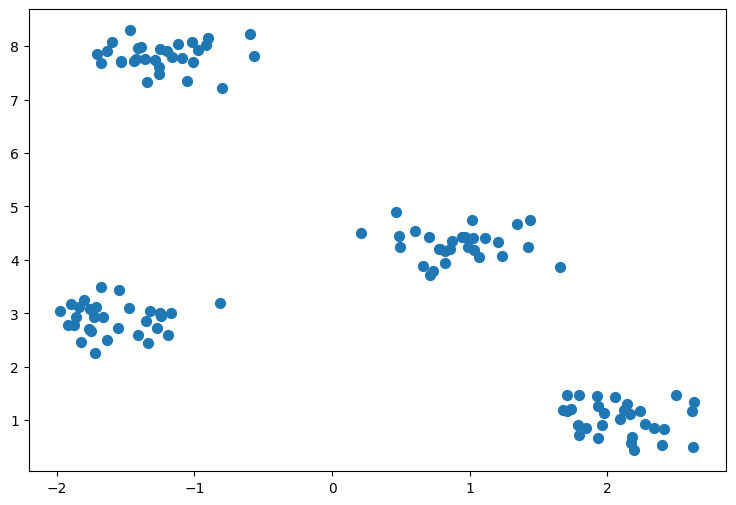

In [58]:
plt.figure(figsize=(9,6))
plt.scatter(X[:, 0], X[:, 1], s=50);

In [59]:
#run DBSCAN function from sklearn package. Note that Epsilon and min=samples here are chosen arbitrarily 
#so we can test it out and adjust accordingly.
dbscan = DBSCAN(eps=0.3, min_samples=2)
clusters = dbscan.fit_predict(X)

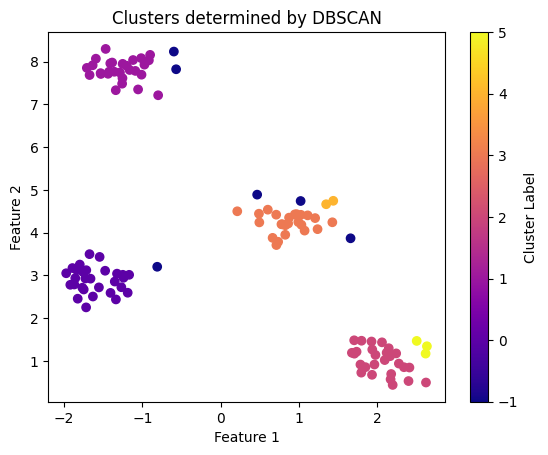

In [60]:
plt.scatter(X[:, 0], X[:, 1], c=clusters, cmap='plasma')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('Clusters determined by DBSCAN')
plt.colorbar(label='Cluster Label')
plt.show()

Note that the above results is not exactly ideal, which is because our parameters are not chosen carefully. Now we adjust the parameters to improve on the result:

In [61]:
new_dbscan = DBSCAN(eps=0.7, min_samples=2)
new_clusters = new_dbscan.fit_predict(X)

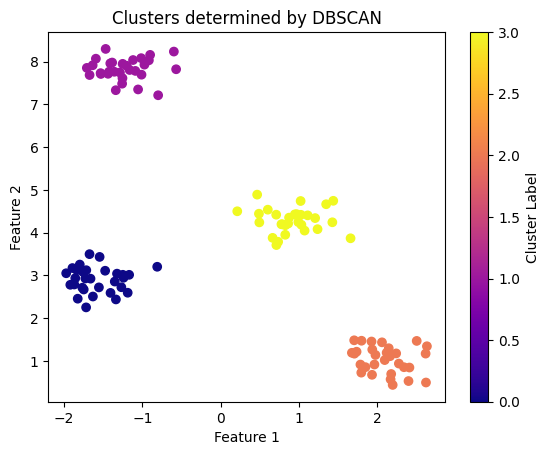

In [62]:
plt.scatter(X[:, 0], X[:, 1], c=new_clusters, cmap='plasma')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('Clusters determined by DBSCAN')
plt.colorbar(label='Cluster Label')
plt.show()

## Part2: DBSCAN for Word Embedding Clustering

We will refenrece the cluster algorithm tutorial notebook Eni posted earlier and use the same example

First let's import/download packages we need for this example. 

In [42]:
import numpy as np
import gensim.downloader as api
from sklearn.cluster import DBSCAN
import sklearn.datasets
from nltk.tokenize import word_tokenize
import nltk

Now, let's read in the dataset.

In [55]:
groups = ['alt.atheism', 'comp.graphics', 'rec.autos', 
          'rec.sport.baseball', 'sci.med', 'talk.politics.guns']


train_data = sklearn.datasets.fetch_20newsgroups(subset='train', categories=groups)
test_data = sklearn.datasets.fetch_20newsgroups(subset='test', categories=groups)
print(len(train_data.filenames), len(test_data.filenames))
data = test_data.data

3395 2261


In [57]:
len(data)

2261

In [58]:
glove_model = api.load('glove-wiki-gigaword-100')

In [78]:
def document_vector(doc):
    words = [word for word in word_tokenize(doc.lower()) if word in glove_model]
    if len(words) >= 1:
        return np.mean(glove_model[words], axis=0)
    else:
        return np.zeros(glove_model.vector_size)

In [79]:
vectorized = np.array([document_vector(doc) for doc in data])

In [80]:
vectorized

array([[-0.34143096,  0.38543767,  0.45011032, ..., -0.20311815,
         0.29827112, -0.20402859],
       [-0.18976374,  0.2376265 ,  0.34035814, ..., -0.38422385,
         0.46699592,  0.10311279],
       [-0.18639372,  0.24688265,  0.48327625, ..., -0.32445464,
         0.38292077,  0.0386395 ],
       ...,
       [-0.19741398,  0.28128844,  0.43004102, ..., -0.3578975 ,
         0.42695105,  0.09466117],
       [-0.07582588,  0.17615509,  0.49833387, ..., -0.268992  ,
         0.5821162 , -0.22354624],
       [-0.15395333,  0.40785834,  0.5004178 , ..., -0.5042534 ,
         0.46475044,  0.00366625]], dtype=float32)

First let's arbitrarily determine the parameters for DBSCAN just to see how the code works.

In [74]:
dbscan = DBSCAN(eps=0.001, min_samples=2, metric='cosine')
clusters = dbscan.fit_predict(vectorized)

In [75]:
import numpy as np
from collections import Counter

cluster_counts = Counter(clusters)
num_clusters = len(cluster_counts) - (1 if -1 in cluster_counts else 0)
num_noise = cluster_counts[-1] if -1 in cluster_counts else 0

print(f"Number of clusters: {num_clusters}")
print(f"Number of noise points: {num_noise}")
print(f"Cluster distribution: {dict(cluster_counts)}")

Number of clusters: 10
Number of noise points: 2240
Cluster distribution: {-1: 2240, 0: 2, 1: 2, 2: 2, 3: 2, 4: 2, 5: 3, 6: 2, 7: 2, 8: 2, 9: 2}


However, we can also use Silhouette Score to help us to decide on the parameters. (Credit to Josie and Sophie!)

In [77]:
from sklearn.metrics import silhouette_score

for eps in np.arange(0.01, 0.1, 0.01):
    model = DBSCAN(eps=eps, min_samples=3, metric='cosine')
    labels = model.fit_predict(vectorized)
    if len(set(labels)) > 1:  # More than 1 cluster plus noise must be present to calculate silhouette
        score = silhouette_score(vectorized, labels)
        print(f"eps: {eps:.1f}, clusters: {len(set(labels))}, silhouette score: {score:.3f}")

eps: 0.0, clusters: 15, silhouette score: 0.003
eps: 0.0, clusters: 4, silhouette score: 0.308
eps: 0.0, clusters: 4, silhouette score: 0.435
eps: 0.0, clusters: 3, silhouette score: 0.506
eps: 0.1, clusters: 3, silhouette score: 0.513
eps: 0.1, clusters: 2, silhouette score: 0.547
eps: 0.1, clusters: 2, silhouette score: 0.587
eps: 0.1, clusters: 2, silhouette score: 0.591
eps: 0.1, clusters: 2, silhouette score: 0.629


Given the balance between granularity and silhouette score, eps = 0.3 might be our best option among the provided results, so we will preceed with that as eps. 

In [40]:
min_samples_values = [5, 6, 7, 8, 9, 10]

In [81]:
for min_samples in min_samples_values:
    # Apply DBSCAN
    dbscan = DBSCAN(eps=0.01, min_samples=min_samples, metric="cosine")
    clusters = dbscan.fit_predict(vectorized)

    # Analyze the clusters
    cluster_counts = Counter(clusters)
    num_clusters = len(cluster_counts) - (1 if -1 in cluster_counts else 0)
    num_noise = cluster_counts[-1] if -1 in cluster_counts else 0

    # Print the results
    print(f"Results for min_samples={min_samples}:")
    print(f"Number of clusters: {num_clusters}")
    print(f"Number of noise points: {num_noise}")
    print(f"Cluster distribution: {dict(cluster_counts)}\n")


Results for min_samples=5:
Number of clusters: 3
Number of noise points: 558
Cluster distribution: {-1: 558, 0: 1668, 1: 30, 2: 5}

Results for min_samples=6:
Number of clusters: 3
Number of noise points: 582
Cluster distribution: {-1: 582, 0: 1655, 1: 18, 2: 6}

Results for min_samples=7:
Number of clusters: 2
Number of noise points: 598
Cluster distribution: {-1: 598, 0: 1645, 1: 18}

Results for min_samples=8:
Number of clusters: 2
Number of noise points: 608
Cluster distribution: {-1: 608, 0: 1637, 1: 16}

Results for min_samples=9:
Number of clusters: 2
Number of noise points: 619
Cluster distribution: {-1: 619, 0: 1626, 1: 16}

Results for min_samples=10:
Number of clusters: 2
Number of noise points: 629
Cluster distribution: {-1: 629, 0: 1621, 1: 11}



## K medoids code example

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn_extra.cluster import KMedoids

In [12]:
##generate a fake dataset

X, y_true = make_blobs(n_samples=120, 
                       centers=4,
                       cluster_std=0.40, 
                       random_state=0)

print(X.shape)
print(y_true.shape)

(120, 2)
(120,)


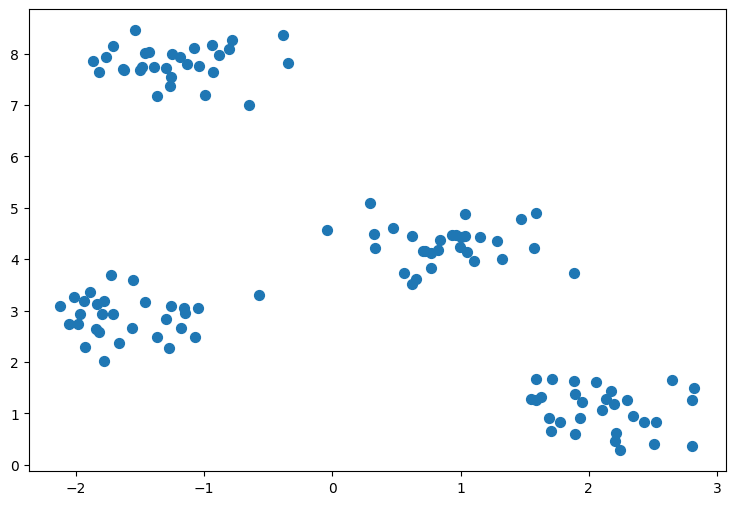

In [13]:
plt.figure(figsize=(9,6))
plt.scatter(X[:, 0], X[:, 1], s=50);

In [14]:
#because this is a fake dataset, we already know that there are 4 clusters.

kmedoids = KMedoids(n_clusters=4, random_state=0)
clusters = kmedoids.fit_predict(X)

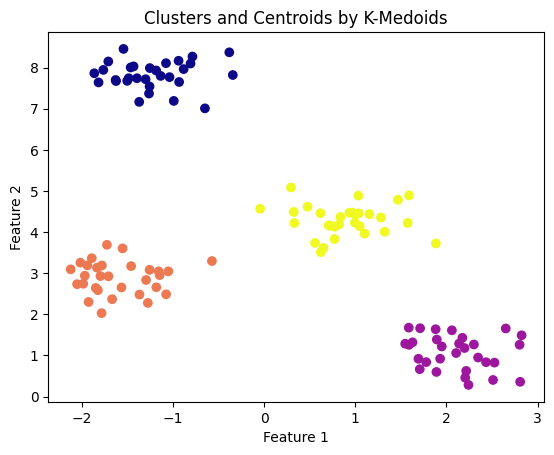

In [15]:
plt.scatter(X[:, 0], X[:, 1], c=clusters, cmap='plasma')
#plt.scatter(kmedoids.cluster_centers_[:, 0], kmedoids.cluster_centers_[:, 1], s=250, marker='*', c='red', label='Centroids')
plt.title('Clusters and Centroids by K-Medoids')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.show()